In [88]:
import sqlite3
import numpy as np
import pandas as pd
import joblib
import copy
from tqdm.notebook import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

sources = ["amides", "sulfonamides", "ROH"]
targets = ["heterocycles", "alkyl amines", "anilines"]
num_desired_rxns = [8,3,2]

In [14]:
### Import arrays
source_desc = joblib.load('./array_joblibs/source_desc_dict.joblib')
target_desc = joblib.load('./array_joblibs/target_desc_dict.joblib')
source_y = joblib.load('./array_joblibs/source_y_dict.joblib')
target_y = joblib.load('./array_joblibs/target_y_dict.joblib')
source_id = joblib.load('./array_joblibs/source_id_dict.joblib')
target_id = joblib.load('./array_joblibs/target_id_dict.joblib')

In [15]:
### Instantiate arrays
amide_desc, amide_y = source_desc["amides"], source_y["amides"]
sulfon_desc, sulfon_y = source_desc["sulfonamides"], source_y["sulfonamides"]
ROH_desc, ROH_y = source_desc["ROH"], source_y["ROH"]
source_desc = [amide_desc, sulfon_desc, ROH_desc]
source_y = [amide_y, sulfon_y, ROH_y]

het_desc, het_y, het_id = target_desc["heterocycles"], target_y["heterocycles"], target_id["heterocycles"]
alkyl_desc, alkyl_y, alkyl_id = target_desc["alkyl amines"], target_y["alkyl amines"], target_id["alkyl amines"]
anil_desc, anil_y, anil_id = target_desc["anilines"], target_y["anilines"], target_id["anilines"]

### Instantiate models with depth-1, num_trees-5
amide_models = [CV_dict_list[0]["Model"][50*i+2] for i in range(10)]
sulfon_models = [CV_dict_list[1]["Model"][50*i+2] for i in range(10)]
ROH_models = [CV_dict_list[2]["Model"][50*i+2] for i in range(10)]

In [8]:
######################################################
#####               Utility  Funcs               #####
######################################################

def concat_source_and_batch(source_X, source_y,
                            target_batch_X, target_batch_y,
                            sample_weight_array,
                            weight_factor):
    ''' Concatenates input arrays, prepares sample_weight_array
    required for .fit(). All outputs will be used as input for
    next round.
    
    Parameters
    ----------
    sample_weight_array : list of ints
        source:1, target:some integer
    weight_factor: int
        sample weight for newly collected target data.
    
    Outputs
    -------
    new_X, new_y : np.2d/1darray
        concatenated X, y arrays
    sample_weight_array : list
        concatenated weight_array
    '''
    new_X = np.vstack(tuple([source_X]+[target_batch_X]))
    new_y = np.concatenate(tuple([source_y]+[target_batch_y]))
    sample_weight_array += [weight_factor]*len(target_batch_y)
    return new_X, new_y, sample_weight_array


def divide_target_arrays(X_desc_target, X_id_target, y_target,
                         idx_rxn_to_run, remaining_idx):
    ''' Splits the target array after simulating experiment conduction.
    
    Parameters
    ----------
    X_desc/id/y_target : np.2darray
        arrays to split
    idx_rxn_to_run : list
        indices of reactions in which exp has been conducted
    remaining_idx : list
        indices of reactions that has not yet been experimented.
    
    Returns
    -------
    rxns_collected, rxns_remaining : tuple of np.ndarrays
    '''
    desc_collected = X_desc_target[idx_rxn_to_run,:]
    id_collected = X_id_target[idx_rxn_to_run,:]
    y_collected = y_target[idx_rxn_to_run]
    
    desc_remaining = X_desc_target[remaining_idx,:]
    id_remaining = X_id_target[remaining_idx,:]
    y_remaining = y_target[remaining_idx]
    
    assert desc_collected.shape[0]+desc_remaining.shape[0]==X_desc_target.shape[0]
    rxns_collected = (desc_collected, id_collected, y_collected)
    rxns_remaining = (desc_remaining, id_remaining, y_remaining)
    return rxns_collected, rxns_remaining


######################################################
#####               Choosing  Rxns               #####
######################################################

def most_confident_rxns(model, X_target_desc, num_rxns):
    ''' Chooses the reactions to conduct based on highest confidence.
    
    Parameters
    ----------
    model : classifier
    X_target_desc : np.2darray
        remaining desc/id target reaction candidates
    num_rxns : int
        number of reactions to select.
        
    Returns
    -------
    idx_rxn_to_run : np.1darray
        indices of rxns to run within X_target_desc
    remaining_idx : np.1darray
        indices of rxns remaining within X_target_desc
    '''
    pred_proba = model.predict_proba(X_target_desc)[:,1]
    confidence = 1-np.sort(pred_proba)[:num_rxns]
    idx_rxn_to_run = np.argsort(pred_proba)[:num_rxns]
    remaining_idx = np.argsort(pred_proba)[num_rxns:]
    return idx_rxn_to_run, remaining_idx, confidence


def highest_variance_btw_trees(model, X_target_desc, num_rxns):
    ''' Chooses reactions which have highest variance of predicted
    probability values across all trees in the RF model.'''
    all_proba = np.zeros((X_target_desc.shape[0],
                          len(model.estimators_)))
    for i,tree in enumerate(model.estimators_):
        all_proba[:,i] = tree.predict_proba(X_target_desc)[:,0]
    var_proba = np.var(all_proba, axis=1)
    pred_proba = model.predict_proba(X_target_desc)[:,1]
    idx_rxn_to_run = np.argsort(var_proba)[-num_rxns:]
    remaining_idx = np.argsort(var_proba)[:-num_rxns]
    return idx_rxn_to_run, remaining_idx, 1-pred_proba[idx_rxn_to_run]


def highest_expectation_plus_std(model, X_target_desc, num_rxns,
                                 coeff):
    ''' Follows upper confidence bound. Selects reactions with
    highest predicted probability values + std across trees.'''
    pred_proba = model.predict_proba(X_target_desc)[:,0]
    all_proba = np.zeros((X_target_desc.shape[0],
                          len(model.estimators_)))
    for i,tree in enumerate(model.estimators_):
        all_proba[:,i] = tree.predict_proba(X_target_desc)[:,0]
    std_proba = np.std(all_proba, axis=1)
    pred_proba = model.predict_proba(X_target_desc)[:,0]
    comb = pred_proba + coeff*std_proba
    idx_rxn_to_run = np.argsort(comb)[-num_rxns:]
    remaining_idx = np.argsort(comb)[:-num_rxns]
    return idx_rxn_to_run, remaining_idx, pred_proba

######################################################
#####               Updating Model               #####
######################################################

def replace_trees(model, new_X, new_y,
                  newly_conducted_X, newly_conducted_y,
                  sample_weight_array,
                  max_depth, random_state):
    '''Within the random forest, replaces trees that predicted 
    at least one result of the conducted experiments incorrectly.
    
    Parameters
    ----------
    new_X, new_y : np.ndarrays
        arrays of the combined source+collected target data.
    newly_conducted_X/y : np.ndarrays
        arrays of the collected target data only.
    sample_weight_array : list
        sample weights for training new model
    max_depth : int
        maximum depth of new tree
    random_state : int
    
    Returns
    -------
    model : random forest classifier
    '''
    tree_inds_to_replace = []
    for i,tree in enumerate(model.estimators_):
        pred_by_tree = tree.predict(newly_conducted_X)
        if len(np.where(pred_by_tree!=newly_conducted_y)[0])!=0:
            tree_inds_to_replace.append(i)
    print(f"    Replacing {len(tree_inds_to_replace)} Trees.")
    if len(tree_inds_to_replace) > 0:
        if len(tree_inds_to_replace)==1:
            dtc = DecisionTreeClassifier(random_state=random_state,
                                         max_features="sqrt",
                                         max_depth=max_depth)
            dtc.fit(new_X, new_y, sample_weight=sample_weight_array)
            model.estimators_[tree_inds_to_replace[0]]=dtc
        else : 
            rfc = RandomForestClassifier(
                            random_state=random_state,
                            max_depth=max_depth,
                            n_estimators = len(tree_inds_to_replace)
                    )
            rfc.fit(new_X, new_y, sample_weight=sample_weight_array)
            for i, ind in enumerate(tree_inds_to_replace) :
                model.estimators_[ind] = rfc.estimators_[i]
    return model


def add_trees(model, new_X, new_y, sample_weight_array,
              num_trees, max_depth, random_state, add_every_iter):
    '''Adds specified number of trees while not changing
    the original model.
    
    Parameters
    ----------
    new_X, new_y : np.ndarrays
        arrays of the reactions to train new trees on.
    sample_weight_array : list
        sample weights for training new model
    num_trees : int
        number of trees to add to the forest.
    max_depth : int
        maximum depth of new tree
    random_state : int
    
    Returns
    -------
    model : random forest classifier
    '''
    rfc = RandomForestClassifier(
                        random_state=random_state,
                        max_depth=max_depth,
                        n_estimators=num_trees,
                )
    rfc.fit(new_X, new_y, sample_weight=sample_weight_array)
    copied_model = copy.deepcopy(model)
    copied_model.estimators_ += rfc.estimators_
    copied_model.n_estimators+= rfc.n_estimators

    return copied_model

In [77]:
######################################################
#####      Actual Iterative Active Learning      #####
######################################################
def explore_target_in_batches(source_model, X_desc_source, y_source,
                              X_desc_target, X_id_target, y_target,
                              rxn_selection_strategy, 
                              model_update_strategy, add_every_iter=True,
                              num_trees_to_add=0, new_max_depth=1,
                              num_rxns_per_batch=3, weight_factor=3, 
                              enough_found=8, random_state=42, coeff=None,
                              print_progress=True):
    ''' Simulates exploration by conducting experiments selected
    by model in batches.
    
    Parameters
    ----------
    rxn_selection_strategy : {"confidence", "confusion", "variance"}
                             or a list with these elements
        strategy to sample reactions to conduct.
    model_update_strategy : {"replace", "add_all", "add_collected", "new"}
        • replace : replaces trees that predicts 'collected rxns' wrong.
        • add_all : adds new trees that are trained on combined data.
        --> should set 'num_trees_to_add' value to be greater than 0.
        • add_collected : adds new trees that are trained only on the newly collected data.
        --> should set 'num_trees_to_add' value to be greater than 0.
        • new : train new RF
        • none: use same model
    add_every_iter : bool
        whether new trees are added every iteration.
        • True : number of trees will be [5,8,11,14,•••]
        • False : number of trees will be [5,8,8,8,8,•••]
    num_trees_to_add : int
        if model_update_strategy=="add" : 
            number of trees to add each iteration.
        if model_update_strategy=="new" : 
            new model will be trained with previous model's 
            number of trees + num_trees_to_add
    new_max_depth : int or list
        • int : fixes the max_depth value across iterations
        • list : changes max_depth value as iteration progresses.
    num_rxns_per_batch : int
        number of reactions to sample each batch.
    weight_factor : int
        weight each collected target data will have,
        compared to source data when being combined
    enough_found : int
        after finding this number of reactions, stop exploring
    print_progress : Bool
        whether to print information on sampled reactions each batch.
        
    Returns
    -------
    rxns_collected_per_batch : list of tuples
        (X_id_array, X_desc_array, y_array) per each iteration.
    confidence_selected_rxns : list of np.1darray
        confidence on selected reactions' desiredness for every iteration.
    model_by_iter : list of classifiers
        models used to select the reactions to conduct each iter.
    '''
    ### 0) Initiation
    rxns_collected_per_batch = [] 
    confidence_selected_rxns = []
    model_by_iter = []
    num_found_by_batch = [0]
    total_num_found = 0
    sample_weight_array = [1]*len(y_source)
    num_trees = len(source_model.estimators_)
    iteration = 1
    ref_source_model = copy.deepcopy(source_model)
    ref_source_desc = copy.deepcopy(X_desc_source)
    while total_num_found < enough_found :
        if print_progress:
            print("-----------"+"-"*len(str(iteration)))
            print(f"Iteration {iteration}")
            print("-----------"+"-"*len(str(iteration)))
        ### 1) Reaction Selection Phase
        if type(rxn_selection_strategy) == str:
            rxn_selection = rxn_selection_strategy
        elif type(rxn_selection_strategy) == list:
            rxn_selection = rxn_selection_strategy[iteration-1]
            
        if rxn_selection=="confidence":
            idx_rxn_to_run, remaining_idx, conf = most_confident_rxns(
                            source_model, X_desc_target, num_rxns_per_batch
                        )
        elif rxn_selection=="variance":
            idx_rxn_to_run, remaining_idx, conf = highest_variance_btw_trees(
                            source_model, X_desc_target, num_rxns_per_batch
                        )
        elif rxn_selection=="ucb":
            idx_rxn_to_run, remaining_idx, conf = highest_expectation_plus_std(
                            source_model, X_desc_target, num_rxns_per_batch, coeff)
        else :
            print("Inappropriate reaction selection strategy.")
            break

        ### 1-1) Update items to return
        rxns_collected, rxns_remaining = divide_target_arrays(
                            X_desc_target, X_id_target, y_target,
                            idx_rxn_to_run, remaining_idx
                        )
        rxns_collected_per_batch.append(rxns_collected)
        confidence_selected_rxns.append(conf)
        num_found = len(np.where(y_target[idx_rxn_to_run]==0)[0]) # 0 because negative is minor for our dataset
        total_num_found += num_found
        num_found_by_batch.append(total_num_found)
    
        if print_progress:
            print(np.hstack((rxns_collected[1][:,2:], 
                             rxns_collected[2].reshape(-1,1))))
            print(f"Found {num_found} rxns.")
            print()
            
        ### 1-2) Update arrays and sample_weight
        if weight_factor != 0:
            X_desc_source, y_source, sample_weight_array = concat_source_and_batch(
                                       X_desc_source, y_source,
                                       rxns_collected[0], rxns_collected[2],
                                       sample_weight_array, weight_factor)
        (X_desc_target, X_id_target, y_target) = rxns_remaining
        
        ### 2) Update Model
        if weight_factor!=0:
            if type(new_max_depth) == int:
                max_depth = new_max_depth
            elif type(new_max_depth) == list:
                max_depth = new_max_depth[iteration-1]

            if model_update_strategy=="replace":
                source_model = replace_trees(
                        source_model, X_desc_source, y_source, 
                        rxns_collected[0], rxns_collected[2],
                        sample_weight_array,
                        max_depth, random_state+iteration
                )
            elif model_update_strategy=="add_all":
                if add_every_iter:
                    source_model = add_trees(
                        source_model, X_desc_source, y_source, 
                        sample_weight_array, num_trees_to_add, 
                        max_depth, random_state+iteration
                    )
                else:
                    source_model = add_trees(
                        ref_source_model, X_desc_source, y_source, 
                        sample_weight_array, num_trees_to_add, 
                        max_depth, random_state+iteration
                    )
                print("Number of trees: ", source_model.n_estimators)
            elif model_update_strategy=="add_collected":
                if add_every_iter:
                    source_model = add_trees(
                            source_model, rxns_collected[0], rxns_collected[2], 
                            [1]*len(rxns_collected[2]), num_trees_to_add, 
                            max_depth, random_state+iteration, add_every_iter
                        )
                else : 
                    print("Number of RXNS to train on: ", len(y_source[ref_source_desc.shape[0]:]))
                    source_model = add_trees(
                            ref_source_model, 
                            X_desc_source[ref_source_desc.shape[0]:,:], 
                            y_source[ref_source_desc.shape[0]:], 
                            [1]*len(y_source[ref_source_desc.shape[0]:]), num_trees_to_add, 
                            max_depth, random_state+iteration, add_every_iter
                        )
                print("Number of trees: ", source_model.n_estimators)
            elif model_update_strategy=="new":
                rfc = RandomForestClassifier(random_state=random_state+iteration,
                                             max_depth=max_depth,
                                             n_estimators=num_trees+num_trees_to_add)
                rfc.fit(X_desc_source, y_source, 
                        sample_weight=sample_weight_array)
                source_model = rfc
            elif model_update_strategy=="none":
                source_model = source_model
            else : 
                print("Inappropriate model update strategy.")
                break
        
        model_by_iter.append(copy.deepcopy(source_model))
        iteration+= 1
        #print(f"Source: {X_desc_source.shape[0]}, Target: {X_desc_target.shape[0]}")
    return rxns_collected_per_batch, confidence_selected_rxns,\
           model_by_iter, num_found_by_batch

In [48]:
def prepare_models(desc_array, y_array, num_models, 
                   n_estimators=5, max_depth=1, random_state=42):
    ''' Prepares differently initiated models.
    
    Parameters
    ----------
    desc_array, y_array : np.2d/1darrays
    num_models : int
        number of models to prepare.
    other arguments : hyperparameters.
    
    Returns
    -------
    model_list : list of RandomForestClassifiers.
    '''
    model_list = []
    for i in range(num_models):
        rfc = RandomForestClassifier(random_state=random_state+i,
                                     n_estimators=n_estimators, 
                                     max_depth=max_depth)
        rfc.fit(desc_array, y_array)
        model_list.append(rfc)
    return model_list


def compare_weights(source, model_list, weight_list, source_desc,
                    source_y, target_desc, target_id, target_y, enough_found,
                    model_update_strategy, perf_dict=None, model_dict=None,
                    print_progress=False, target="heterocycle", random_state=42):
    ''' Repeats active learning experiments for all models,
    for all target data importance values (weights).
    
    Parameters
    ----------
    source : str
        name of nucleophile domain.
    model_list : list of RandomForestClassifiers.
        output of function above.
    weight_list : list of ints.
        importance values to consider.
        • zero corresponds to passive modeling (no update).
    source_desc, source_y : np.2d/1darrays
    target_desc, target_id, target_y : np.2d/2d/1darrays
    enough_found : int
        total number of reactions to be found.
    model_update_strategy : str
        • replace : replaces trees that predicts 'collected rxns' wrong.
        • add_all : adds new trees that are trained on combined data.
        --> should set 'num_trees_to_add' value to be greater than 0.
        • add_collected : adds new trees that are trained only on the newly collected data.
        --> should set 'num_trees_to_add' value to be greater than 0.
        • new : train new RF
        • none: use same model
    perf_dict, model_dict : None or dict
        if not None, append results to these dicts
    print_progress : bool
        whether to print which rxns were chosen and decision threshold values.
    random_state: int
    
    Returns
    -------
    all_active_perfs : dict
        stores results of all experiments.
    all_models : dict
        stores all models that were trained every iteration.
    '''
    if perf_dict is None and model_dict is None :
        all_active_perfs = {}
        all_models = {}
    else :
        all_active_perfs = copy.deepcopy(perf_dict)
        all_models = copy.deepcopy(model_dict)
    scenario = f"{source}_to_{target}"
    all_active_perfs.update({scenario:{
                "num_rxns_conducted":[],
                "num_rxns_found":[],
                "strategy":[],
                "weight":[]
        }})
    all_models.update({scenario:{
                "weight":[],
                "models":[],
                "arrays":[]
    }})    
    for i, model in enumerate(tqdm(model_list)) :
        for weight in weight_list :
            rxns_collected_per_batch, confidence_selected_rxns,\
            model_by_iter, num_found_by_batch = explore_target_in_batches(
                            model, source_desc, source_y,
                            target_desc, target_id, target_y,
                            "confidence", "new", 
                            weight_factor=weight, 
                            enough_found=enough_found,
                            print_progress=False,
                            random_state=random_state+i
                        )
            if len(num_found_by_batch)<16 : 
                num_found_by_batch += [num_found_by_batch[-1]]*(16-len(num_found_by_batch))
                all_active_perfs[scenario]["num_rxns_found"] += num_found_by_batch
            elif len(num_found_by_batch)==16:
                all_active_perfs[scenario]["num_rxns_found"] += num_found_by_batch
            all_active_perfs[scenario]["num_rxns_conducted"] += [3*x for x in range(15)]
            all_active_perfs[scenario]["num_rxns_conducted"] += [43]
            all_active_perfs[scenario]["strategy"]+=[strategy]*16
            all_active_perfs[scenario]["weight"] += [weight]*16
                
            all_models[scenario]["weight"] += [weight]
            all_models[scenario]["models"] += [model_by_iter]
            all_models[scenario]["arrays"] += [rxns_collected_per_batch]
    return all_active_perfs, all_models


def plot_AL_performance_by_weight(source, perf_dict, enough_found=8,
                                  ci=None, target="heterocycle",
                                  filename=None):
    ''' Plots average number of desired reactions found each
    iteration.
    
    Parameters
    ----------
    source : str
        nucleophile domain name.
    perf_dict : dict
        output of function above.
    enough_found : int
        number of desired rxns.
    ci : None or int
        confidence interval. 
    filename : str or None
    
    Returns
    -------
    None
    '''
    scenario = f"{source}_to_{target}"
    fig, ax = plt.subplots()
    sns.lineplot(x="num_rxns_conducted", y="num_rxns_found",
                 hue="weight", style="weight", markers=True,
                 alpha=0.7, ci=ci,
                 data=perf_dict[scenario])
    ax.set_xlabel("Number of Reactions Conducted", fontsize=14)
    ax.set_ylabel("Number of Reactions Found", fontsize=14)
    if enough_found == 8 :
        ax.set_yticks(2*np.arange(5))
    elif enough_found <=4 :
        ax.set_yticks(np.arange(enough_found+1))
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    if filename is not None:
        fig.savefig(f"./figures/{filename}.pdf", format="pdf",
                    dpi=300)

In [38]:
amide_OA_model = joblib.load("./array_joblibs/amide_model.joblib")
sulfon_OA_model = joblib.load("./array_joblibs/sulfon_model.joblib")
ROH_OA_model = joblib.load("./array_joblibs/ROH_model.joblib")
OA_models = [amide_OA_model, sulfon_OA_model, ROH_OA_model]

### Performance of models with no updates on aniline & alkyl amine

In [60]:
def passive_for_anil_or_alkyl(source_list, source_desc_list, source_y_list,
                              target_desc, target_id, target_y, target,
                              OA_model_list, num_models=25):
    for i, source in enumerate(source_list):
        model_list = prepare_models(source_desc_list[i], 
                                    source_y_list[i], 
                                    num_models)
        if i==0 :
            perf_dict = None
            model_dict = None
            mech_perf_dict = None
            mech_model_dict = None
        perf_dict, model_dict = compare_weights(
                    source, model_list, [0], 
                    source_desc_list[i], source_y_list[i], 
                    target_desc, target_id, target_y,
                    len(target_y)-sum(target_y), 
                    "new", perf_dict=perf_dict, model_dict=model_dict,
                    target=target
        )
        mech_perf_dict, mech_model_dict = compare_weights(
                    source, [OA_model_list[i]], [0], 
                    source_desc_list[i], source_y_list[i], 
                    target_desc, target_id, target_y,
                    len(target_y)-sum(target_y), 
                    "new",perf_dict=mech_perf_dict, model_dict=mech_model_dict,
                    target=target
        )
    return perf_dict, mech_perf_dict


def plot_passive_perfs(perf_dict, mech_perf_dict, source_list,
                      target, save=False):
    for i,source in enumerate(source_list) :
        scenario = f"{source}_to_{target}"
        fig, ax = plt.subplots()
        sns.lineplot(x="num_rxns_conducted", y="num_rxns_found",
                     hue="weight", style="weight", markers=True,
                     alpha=0.7, ci=95, legend=False,
                     data=perf_dict[scenario], ax=ax)
        sns.lineplot(x="num_rxns_conducted", y="num_rxns_found",
                     hue="weight", style="weight", markers=True,legend=False,
                     alpha=0.7, ci=None, palette="plasma",
                     data=mech_perf_dict[scenario], ax=ax)
        ax.set_xlabel("Number of Reactions Conducted", fontsize=14)
        ax.set_ylabel("Number of Reactions Found", fontsize=14)
        ax.set_yticks(np.arange(3))
        custom_lines = [Line2D([0], [0], color='#b64b7d', lw=4),
                        Line2D([0], [0], color='tab:blue', lw=4)]
        ax.legend(custom_lines, ['Mechanism', 'Random'], 
                   loc='lower right', fontsize=10)
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)
        if save:
            fig.savefig(f"./figures/figureS5_{scenario}.pdf", format="pdf",
                        dpi=300)

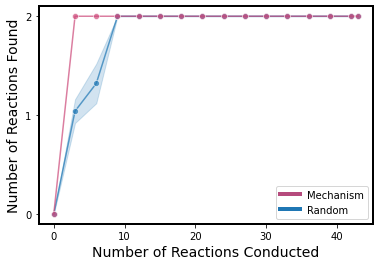

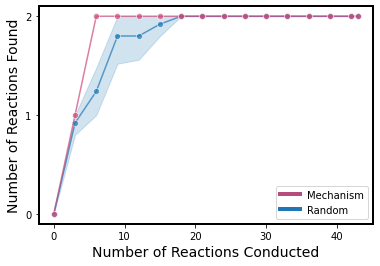

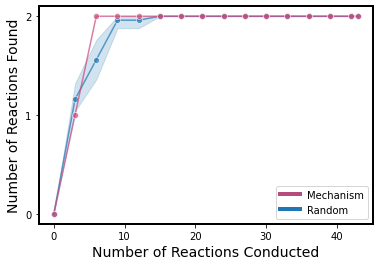

In [62]:
anil_perf_dict, anil_mech_perf_dict = passive_for_anil_or_alkyl(
                sources, source_desc, source_y,
                anil_desc, anil_id, anil_y, "aniline",
                OA_models
)
plot_passive_perfs(anil_perf_dict, anil_mech_perf_dict, sources,
                   "aniline")

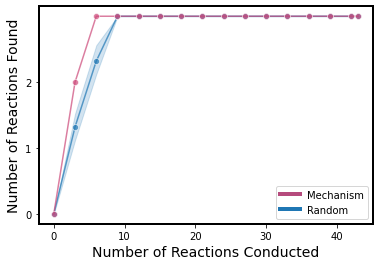

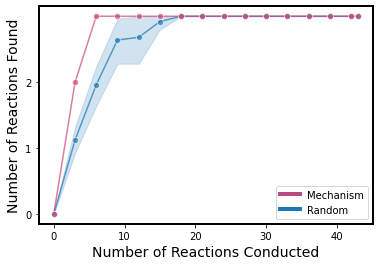

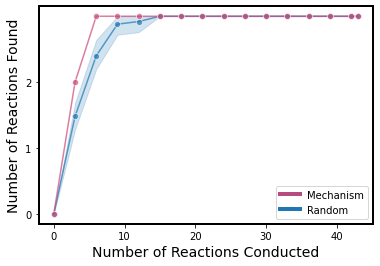

In [63]:
alkyl_perf_dict, alkyl_mech_perf_dict = passive_for_anil_or_alkyl(
                sources, source_desc, source_y,
                alkyl_desc, alkyl_id, alkyl_y, "alkyl amine",
                OA_models
)
plot_passive_perfs(alkyl_perf_dict, alkyl_mech_perf_dict, sources,
                   "alkyl amine")

## Target : heterocycle
## 1) Hyperparameter fixed (max_depth=1, num_trees=5)

### Comparing target importance : 1 vs 3 vs 5 (strategy = confidence)

In [74]:
all_source_models = []
for i, source in enumerate(sources):
    model_list = prepare_models(source_desc[i], source_y[i], 25)
    all_source_models.append(model_list)
    if i==0 :
        perf_dict = None
        model_dict = None
    perf_dict, model_dict=compare_weights(
                source, model_list, [0,1,3,5], 
                source_desc[i], source_y[i], het_desc, het_id, het_y, 
                len(het_y)-sum(het_y), 
                "new", perf_dict=perf_dict, model_dict=model_dict)

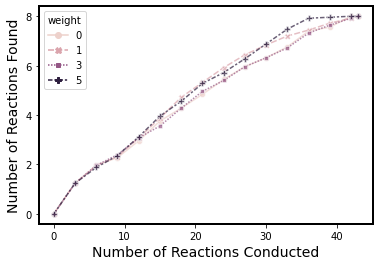

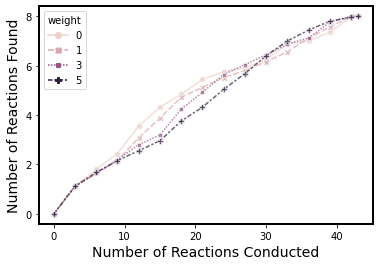

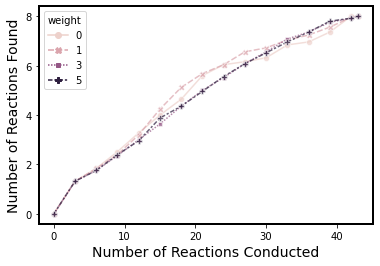

In [27]:
for i,source in enumerate(sources) :
    if i==0 : filename="figure5"
    elif i==1 : filename="figureS5_sulfon"
    else : filename = "figureS5_ROH"
    plot_AL_performance_by_weight(source, perf_dict, filename)

### Analysis

In [93]:
def compute_area(num_rxn_found, num_rxn_conducted):
    ''' Computes the area below the AL performance curve.
    
    Parameters
    ----------
    num_rxn_found : list
        cumulative number of reactions found at each iteration.
    num_rxn_conducted : list
        cumulative number of reactions conducted.
    
    Returns
    -------
    area : float
        area under the curve.
    '''
    area = 0
    for i, found in enumerate(num_rxn_found[:-1]):
        next_found = num_rxn_found[i+1]
        conducted, next_conducted = num_rxn_conducted[i:i+2]
        area += 0.5*(found+next_found)*(next_conducted-conducted)
    return area


def calc_area_by_scenario(AL_result_dict, sources=sources, num_weights=4, num_models=25,
                          num_batches=16):
    ''' Computes area under the AL performance curve for all cases in the result_dict.'''
    area_by_scenario = {}
    for source in sources : 
        scenario = f"{source}_to_heterocycle"
        areas = np.zeros((num_weights,num_models)) 

        conducted = AL_result_dict[scenario]["num_rxns_conducted"]
        found = AL_result_dict[scenario]["num_rxns_found"]

        for i in range(num_models):
            for j in range(num_weights):
                start, end = num_batches*num_weights*i+num_batches*j, num_batches*num_weights*i+num_batches*(j+1)
                areas[j,i] = compute_area(found[start:end], conducted[start:end])
        area_by_scenario.update({scenario:areas})
    return area_by_scenario


def get_roc_and_probs_by_batch(dict_of_models, source, model_ind, 
                               weight_ind, source_desc, source_y,
                               num_weights_considered=4, num_batches=16):
    ''' Prepares arrays of how models updated at the end of each iteration makes predictions
    on data in hand (source data + target data collected upto that batch).
    
    Parameters
    ----------
    dict_of_models : dict
        all_models dict four cells above this.
    source : {"amides", "sulfonamides", "ROH"}
        source domain.
    model_ind, weight_ind : int
        • index of model = 25*(model_num)+(ind_of_weight)
        • index of weight
    num_batches : int
        number of batches = num_target_rxns//num_rxns_per_batch + 2 (initial and end)
    
    Returns
    -------
    roc_source_rxns, roc_collected_rxns : np.1darray
        updated model's ROC on source rxns only / collected target rxns only
    prob_desired_rxns : np.1darray
        Average predicted probability values of target rxns with desired outcomes.
    '''
    scenario = f"{source}_to_heterocycle"
    models_by_batch = dict_of_models[scenario]["models"][num_weights_considered*model_ind+weight_ind]
    arrays_by_batch = dict_of_models[scenario]["arrays"][num_weights_considered*model_ind+weight_ind]
    roc_source_rxns = np.zeros(num_batches)
    roc_collected_rxns = np.zeros(num_batches)
    prob_desired_rxns = np.zeros(num_batches)

    for i, model in enumerate(models_by_batch):
        if i==0 : 
            (X, y) = arrays_by_batch[0][0], arrays_by_batch[0][2] 
        else : 
            arrays_to_consider = arrays_by_batch[:i]
            X = np.vstack(tuple([x[0] for x in arrays_to_consider]))
            y = np.concatenate(tuple([x[2] for x in arrays_to_consider]))
        # ROC-AUC of model on source reactions
        roc = roc_auc_score(source_y,
                            model.predict_proba(source_desc)[:,1])
        roc_source_rxns[i+1] = roc
        # ROC-AUC of model on collected target rxns up to this batch
        proba = model.predict_proba(X)[:,1]
        if sum(y) not in [len(y),0]:
            roc_collected_rxns[i+1] = roc_auc_score(y, proba)
            prob_desired_rxns[i+1] = np.mean(proba[np.where(y==0)[0]])
        else : 
            roc_collected_rxns[i+1] = 0
            if sum(y)==len(y) : prob_desired_rxns[i+1] = 0
            else : prob_desired_rxns[i+1] = np.mean(proba[np.where(y==0)[0]])
        # Predicted probabilities of collected 'desired rxns'
        
        
    if len(models_by_batch)< num_batches-2: #-2 due to the first and last
        roc_collected_rxns[i+2:] = roc_collected_rxns[i+1]
        prob_desired_rxns[i+2:] = prob_desired_rxns[i+1]
        roc_source_rxns[i+2:] = roc_source_rxns[i+1]        

    return roc_source_rxns, roc_collected_rxns, prob_desired_rxns


def prep_dict_to_plot_AL_and_ROC(AL_result_dict, source, model_ind,
                                 weight_ind, roc_source_rxns, roc_collected_rxns, num_enough=8,
                                 num_weights_considered=4, num_batches=16):
    ''' Prepares a dictionary for plotting ROC-AUC values of each model along with
    active learning performance.
    
    Parameters
    ----------
    AL_result_dict : dict
        corresponds to all_active_perfs 4 cells above
    source : {"amides", "sulfonamides", "ROH"}
        source domain.
    start_ind : int
        starting index of list which the system of interest is recorded in AL_result_dict
    roc_source_rxns, roc_collected_rxns : np.1darray
        outcomes of function above
    
    Returns
    -------
    dict_to_plot : dict
    '''
    start_ind = num_batches*num_weights_considered*model_ind+num_batches*weight_ind
    dict_to_plot = {
            "num_rxns_conducted":[],
            "score":[],
            "measure":[],
    }
    scenario = f"{source}_to_heterocycle"
    for i in range(3):
        dict_to_plot["num_rxns_conducted"] += AL_result_dict[scenario]['num_rxns_conducted'][start_ind:start_ind+num_batches]

    dict_to_plot["measure"] += ["Num Rxns Found"]*num_batches
    roc_names = ["Source ROC", "Target ROC"]
    for i in range(2):
        dict_to_plot["measure"] += [roc_names[i]]*num_batches

    dict_to_plot["score"] += [x/num_enough for x in AL_result_dict[scenario]['num_rxns_found'][start_ind:start_ind+num_batches]]
    dict_to_plot["score"] += list(roc_source_rxns)
    dict_to_plot["score"] += list(roc_collected_rxns)
                              
    return dict_to_plot
                              

def prep_dict_to_plot_AL_and_prob(AL_result_dict, source, model_ind,
                                 weight_ind, prob_desired_rxns, num_enough,
                                 num_weights_considered=4, num_batches=16):
    ''' Prepares a dictionary for plotting predicted probability values of desired target rxns by each model.
    
    Parameters
    ----------
    AL_result_dict : dict
        corresponds to all_active_perfs 4 cells above
    source : {"amides", "sulfonamides", "ROH"}
        source domain.
    start_ind : int
        starting index of list which the system of interest is recorded in AL_result_dict
    prob_desired_rxns : np.1darray
        outcomes of function above
    num_enough : int
        total number of desired target rxns.
    
    Returns
    -------
    dict_to_plot : dict
    '''
    start_ind = num_batches*num_weights_considered*model_ind+num_batches*weight_ind
    dict_to_plot = {
            "num_rxns_conducted":[],
            "score":[],
            "measure":[],
    }
    scenario = f"{source}_to_heterocycle"
    
    for i in range(2):
        dict_to_plot["num_rxns_conducted"] += AL_result_dict[scenario]['num_rxns_conducted'][start_ind:start_ind+num_batches]

    dict_to_plot["measure"] += ["Num Rxns Found"]*num_batches
    dict_to_plot["measure"] += ["Predicted Target Prob"]*num_batches

    dict_to_plot["score"] += [x/num_enough for x in AL_result_dict[scenario]['num_rxns_found'][start_ind:start_ind+num_batches]]
    dict_to_plot["score"] += [0]
    dict_to_plot["score"] += list(1-prob_desired_rxns[1:])
                              
    return dict_to_plot      
                              
                              
def plot_AL_and_ROC(dict_to_plot, ylabel_second_half, filename=None):
    fig, ax = plt.subplots()
    sns.lineplot(x="num_rxns_conducted", y="score",
                 hue="measure", style="measure", markers=True,
                 data=dict_to_plot)
    ax.set_xlabel("Number of Reactions Conducted", fontsize=14)
    ax.set_ylabel(f"Portion of Rxns Found\nor {ylabel_second_half}", fontsize=14)
    #ax.legend(bbox_to_anchor=(1.01,0.99))
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    if filename is not None :
        fig.savefig(f"./figures/{filename}.pdf", format="pdf", dpi=300)

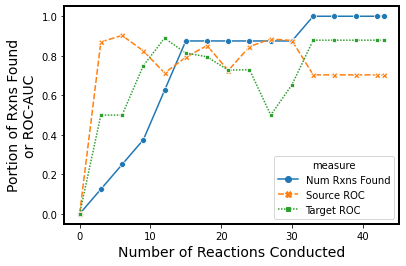

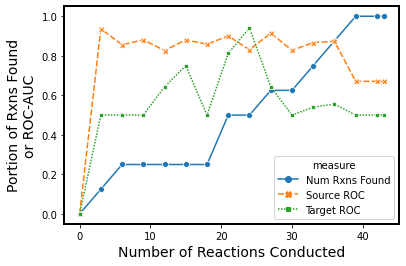

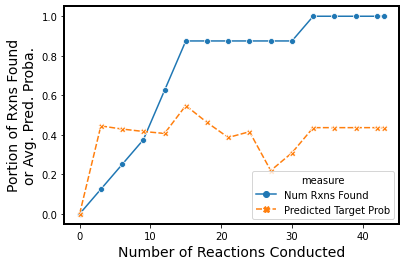

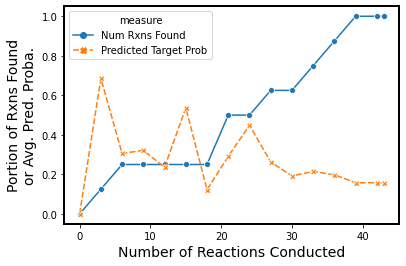

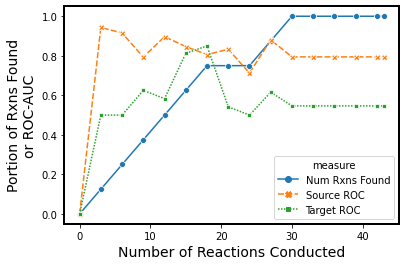

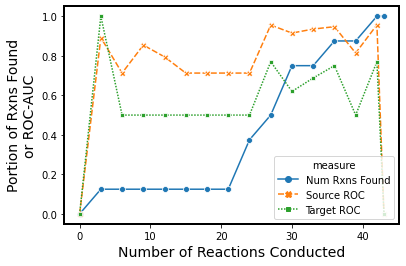

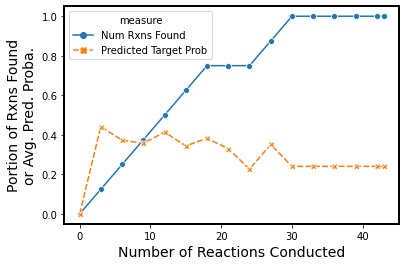

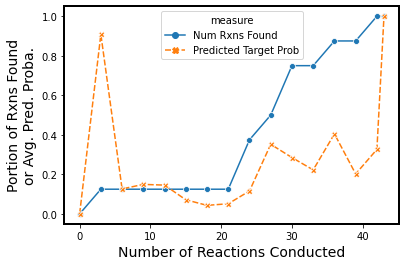

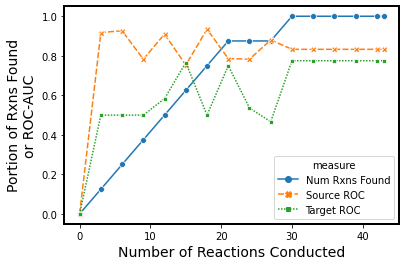

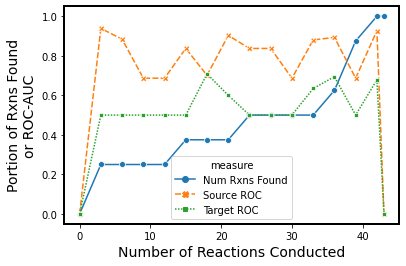

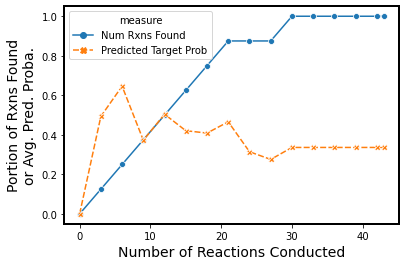

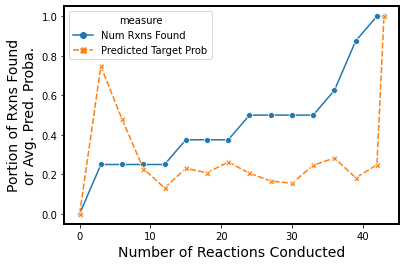

In [73]:
area_by_scenario = calc_area_by_scenario(perf_dict)
for i,source in enumerate(sources):
    areas = area_by_scenario[f"{source}_to_heterocycle"]
    worst_idx, best_idx = np.argsort(areas[3,:])[0], np.argsort(areas[3,:])[-1]
    
    roc_source_rxns_best_system, roc_collected_rxns_best_system,\
    prob_desired_rxns_best_system  = get_roc_and_probs_by_batch(model_dict, source, best_idx, 3,
                                                                source_desc[i], source_y[i]) 
    roc_source_rxns_worst_system, roc_collected_rxns_worst_system,\
    prob_desired_rxns_worst_system  = get_roc_and_probs_by_batch(model_dict, source, worst_idx, 3,
                                                                source_desc[i], source_y[i])
    
    AL_and_ROC_best_system = prep_dict_to_plot_AL_and_ROC(perf_dict, source, best_idx, 3, 
                                                      roc_source_rxns_best_system, roc_collected_rxns_best_system)
    AL_and_prob_best_system = prep_dict_to_plot_AL_and_prob(perf_dict, source, best_idx, 3, 
                                                            prob_desired_rxns_best_system, 8)
    AL_and_ROC_worst_system = prep_dict_to_plot_AL_and_ROC(perf_dict, source, worst_idx, 3, 
                                                           roc_source_rxns_worst_system, roc_collected_rxns_worst_system)
    AL_and_prob_worst_system = prep_dict_to_plot_AL_and_prob(perf_dict, source, worst_idx, 3, 
                                                            prob_desired_rxns_worst_system, 8)
    
    plot_AL_and_ROC(AL_and_ROC_best_system, "ROC-AUC", f"figureS8_best_{source}_ROC_AUC")
    plot_AL_and_ROC(AL_and_ROC_worst_system, "ROC-AUC", f"figureS8_worst_{source}_ROC_AUC")

    plot_AL_and_ROC(AL_and_prob_best_system, "Avg. Pred. Proba.", f"figureS8_best_{source}_target_confidence")
    plot_AL_and_ROC(AL_and_prob_worst_system, "Avg. Pred. Proba.", f"figureS8_worst_{source}_target_confidence")

## 2) Adding fixed number of trees

In [78]:
adding_fixed_num_tree_system = {}
adding_fixed_num_tree_models = {}

for i, source in enumerate(sources):
    model_list = all_source_models[i]
    scenario = f"{source}_to_heterocycle"
    adding_fixed_num_tree_system.update({scenario:{
                "num_rxns_conducted":[],
                "num_rxns_found":[],
                "Number of Additional Trees":[]
        }})
    adding_fixed_num_tree_models.update({scenario:{
                "models":[],
                "arrays":[]
        }})
    
    for j, model in enumerate(tqdm(model_list)):
        for num_trees in [3,5,7]:
            model_to_use = copy.deepcopy(model)
            rxns_collected_per_batch, confidence_selected_rxns,\
            model_by_iter, num_found_by_batch = explore_target_in_batches(
                        model_to_use, source_desc[i], source_y[i],
                        het_desc, het_id, het_y,
                        "confidence", "add_collected", add_every_iter=False,
                        num_trees_to_add=num_trees,
                        print_progress=False,
                        random_state=42+k
                    )
            if len(num_found_by_batch)<16 : 
                num_found_by_batch += [num_found_by_batch[-1]]*(16-len(num_found_by_batch))
                adding_fixed_num_tree_system[scenario]["num_rxns_found"] += num_found_by_batch
            elif len(num_found_by_batch)==16:
                adding_fixed_num_tree_system[scenario]["num_rxns_found"] += num_found_by_batch
            adding_fixed_num_tree_system[scenario]["num_rxns_conducted"] += [3*x for x in range(15)]
            adding_fixed_num_tree_system[scenario]["num_rxns_conducted"] += [43]
            adding_fixed_num_tree_system[scenario]["Number of Additional Trees"] += [num_trees]*16
            adding_fixed_num_tree_models[scenario]["models"] += [model_by_iter]
            adding_fixed_num_tree_models[scenario]["arrays"] += [rxns_collected_per_batch]

Number of RXNS to train on:  3
Number of trees:  8
Number of RXNS to train on:  6
Number of trees:  8
Number of RXNS to train on:  9
Number of trees:  8
Number of RXNS to train on:  12
Number of trees:  8
Number of RXNS to train on:  15
Number of trees:  8
Number of RXNS to train on:  18
Number of trees:  8
Number of RXNS to train on:  21
Number of trees:  8
Number of RXNS to train on:  24
Number of trees:  8
Number of RXNS to train on:  27
Number of trees:  8
Number of RXNS to train on:  30
Number of trees:  8
Number of RXNS to train on:  33
Number of trees:  8
Number of RXNS to train on:  36
Number of trees:  8
Number of RXNS to train on:  3
Number of trees:  10
Number of RXNS to train on:  6
Number of trees:  10
Number of RXNS to train on:  9
Number of trees:  10
Number of RXNS to train on:  12
Number of trees:  10
Number of RXNS to train on:  15
Number of trees:  10
Number of RXNS to train on:  18
Number of trees:  10
Number of RXNS to train on:  21
Number of trees:  10
Number of R

Number of trees:  10
Number of RXNS to train on:  21
Number of trees:  10
Number of RXNS to train on:  24
Number of trees:  10
Number of RXNS to train on:  27
Number of trees:  10
Number of RXNS to train on:  3
Number of trees:  12
Number of RXNS to train on:  6
Number of trees:  12
Number of RXNS to train on:  9
Number of trees:  12
Number of RXNS to train on:  12
Number of trees:  12
Number of RXNS to train on:  15
Number of trees:  12
Number of RXNS to train on:  18
Number of trees:  12
Number of RXNS to train on:  21
Number of trees:  12
Number of RXNS to train on:  24
Number of trees:  12
Number of RXNS to train on:  27
Number of trees:  12
Number of RXNS to train on:  3
Number of trees:  8
Number of RXNS to train on:  6
Number of trees:  8
Number of RXNS to train on:  9
Number of trees:  8
Number of RXNS to train on:  12
Number of trees:  8
Number of RXNS to train on:  15
Number of trees:  8
Number of RXNS to train on:  18
Number of trees:  8
Number of RXNS to train on:  21
Numbe

Number of trees:  12
Number of RXNS to train on:  21
Number of trees:  12
Number of RXNS to train on:  24
Number of trees:  12
Number of RXNS to train on:  27
Number of trees:  12
Number of RXNS to train on:  30
Number of trees:  12
Number of RXNS to train on:  3
Number of trees:  8
Number of RXNS to train on:  6
Number of trees:  8
Number of RXNS to train on:  9
Number of trees:  8
Number of RXNS to train on:  12
Number of trees:  8
Number of RXNS to train on:  15
Number of trees:  8
Number of RXNS to train on:  18
Number of trees:  8
Number of RXNS to train on:  21
Number of trees:  8
Number of RXNS to train on:  24
Number of trees:  8
Number of RXNS to train on:  27
Number of trees:  8
Number of RXNS to train on:  3
Number of trees:  10
Number of RXNS to train on:  6
Number of trees:  10
Number of RXNS to train on:  9
Number of trees:  10
Number of RXNS to train on:  12
Number of trees:  10
Number of RXNS to train on:  15
Number of trees:  10
Number of RXNS to train on:  18
Number o

Number of trees:  10
Number of RXNS to train on:  24
Number of trees:  10
Number of RXNS to train on:  3
Number of trees:  12
Number of RXNS to train on:  6
Number of trees:  12
Number of RXNS to train on:  9
Number of trees:  12
Number of RXNS to train on:  12
Number of trees:  12
Number of RXNS to train on:  15
Number of trees:  12
Number of RXNS to train on:  18
Number of trees:  12
Number of RXNS to train on:  21
Number of trees:  12
Number of RXNS to train on:  24
Number of trees:  12
Number of RXNS to train on:  3
Number of trees:  8
Number of RXNS to train on:  6
Number of trees:  8
Number of RXNS to train on:  9
Number of trees:  8
Number of RXNS to train on:  12
Number of trees:  8
Number of RXNS to train on:  15
Number of trees:  8
Number of RXNS to train on:  18
Number of trees:  8
Number of RXNS to train on:  21
Number of trees:  8
Number of RXNS to train on:  24
Number of trees:  8
Number of RXNS to train on:  27
Number of trees:  8
Number of RXNS to train on:  30
Number o

Number of trees:  10
Number of RXNS to train on:  12
Number of trees:  10
Number of RXNS to train on:  15
Number of trees:  10
Number of RXNS to train on:  18
Number of trees:  10
Number of RXNS to train on:  21
Number of trees:  10
Number of RXNS to train on:  24
Number of trees:  10
Number of RXNS to train on:  27
Number of trees:  10
Number of RXNS to train on:  3
Number of trees:  12
Number of RXNS to train on:  6
Number of trees:  12
Number of RXNS to train on:  9
Number of trees:  12
Number of RXNS to train on:  12
Number of trees:  12
Number of RXNS to train on:  15
Number of trees:  12
Number of RXNS to train on:  18
Number of trees:  12
Number of RXNS to train on:  21
Number of trees:  12
Number of RXNS to train on:  24
Number of trees:  12
Number of RXNS to train on:  27
Number of trees:  12



Number of RXNS to train on:  3
Number of trees:  8
Number of RXNS to train on:  6
Number of trees:  8
Number of RXNS to train on:  9
Number of trees:  8
Number of RXNS to train on:  12
Number of trees:  8
Number of RXNS to train on:  15
Number of trees:  8
Number of RXNS to train on:  18
Number of trees:  8
Number of RXNS to train on:  21
Number of trees:  8
Number of RXNS to train on:  24
Number of trees:  8
Number of RXNS to train on:  27
Number of trees:  8
Number of RXNS to train on:  30
Number of trees:  8
Number of RXNS to train on:  33
Number of trees:  8
Number of RXNS to train on:  3
Number of trees:  10
Number of RXNS to train on:  6
Number of trees:  10
Number of RXNS to train on:  9
Number of trees:  10
Number of RXNS to train on:  12
Number of trees:  10
Number of RXNS to train on:  15
Number of trees:  10
Number of RXNS to train on:  18
Number of trees:  10
Number of RXNS to train on:  21
Number of trees:  10
Number of RXNS to train on:  24
Number of trees:  10
Number of 

Number of trees:  10
Number of RXNS to train on:  3
Number of trees:  12
Number of RXNS to train on:  6
Number of trees:  12
Number of RXNS to train on:  9
Number of trees:  12
Number of RXNS to train on:  12
Number of trees:  12
Number of RXNS to train on:  15
Number of trees:  12
Number of RXNS to train on:  18
Number of trees:  12
Number of RXNS to train on:  21
Number of trees:  12
Number of RXNS to train on:  24
Number of trees:  12
Number of RXNS to train on:  27
Number of trees:  12
Number of RXNS to train on:  3
Number of trees:  8
Number of RXNS to train on:  6
Number of trees:  8
Number of RXNS to train on:  9
Number of trees:  8
Number of RXNS to train on:  12
Number of trees:  8
Number of RXNS to train on:  15
Number of trees:  8
Number of RXNS to train on:  18
Number of trees:  8
Number of RXNS to train on:  21
Number of trees:  8
Number of RXNS to train on:  24
Number of trees:  8
Number of RXNS to train on:  27
Number of trees:  8
Number of RXNS to train on:  30
Number o

Number of trees:  10
Number of RXNS to train on:  21
Number of trees:  10
Number of RXNS to train on:  24
Number of trees:  10
Number of RXNS to train on:  27
Number of trees:  10
Number of RXNS to train on:  3
Number of trees:  12
Number of RXNS to train on:  6
Number of trees:  12
Number of RXNS to train on:  9
Number of trees:  12
Number of RXNS to train on:  12
Number of trees:  12
Number of RXNS to train on:  15
Number of trees:  12
Number of RXNS to train on:  18
Number of trees:  12
Number of RXNS to train on:  21
Number of trees:  12
Number of RXNS to train on:  24
Number of trees:  12
Number of RXNS to train on:  27
Number of trees:  12
Number of RXNS to train on:  30
Number of trees:  12
Number of RXNS to train on:  33
Number of trees:  12
Number of RXNS to train on:  3
Number of trees:  8
Number of RXNS to train on:  6
Number of trees:  8
Number of RXNS to train on:  9
Number of trees:  8
Number of RXNS to train on:  12
Number of trees:  8
Number of RXNS to train on:  15
Num

Number of RXNS to train on:  12
Number of trees:  12
Number of RXNS to train on:  15
Number of trees:  12
Number of RXNS to train on:  18
Number of trees:  12
Number of RXNS to train on:  21
Number of trees:  12
Number of RXNS to train on:  24
Number of trees:  12
Number of RXNS to train on:  27
Number of trees:  12
Number of RXNS to train on:  30
Number of trees:  12
Number of RXNS to train on:  3
Number of trees:  8
Number of RXNS to train on:  6
Number of trees:  8
Number of RXNS to train on:  9
Number of trees:  8
Number of RXNS to train on:  12
Number of trees:  8
Number of RXNS to train on:  15
Number of trees:  8
Number of RXNS to train on:  18
Number of trees:  8
Number of RXNS to train on:  21
Number of trees:  8
Number of RXNS to train on:  24
Number of trees:  8
Number of RXNS to train on:  27
Number of trees:  8
Number of RXNS to train on:  30
Number of trees:  8
Number of RXNS to train on:  3
Number of trees:  10
Number of RXNS to train on:  6
Number of trees:  10
Number o

Number of trees:  12
Number of RXNS to train on:  24
Number of trees:  12
Number of RXNS to train on:  27
Number of trees:  12
Number of RXNS to train on:  3
Number of trees:  8
Number of RXNS to train on:  6
Number of trees:  8
Number of RXNS to train on:  9
Number of trees:  8
Number of RXNS to train on:  12
Number of trees:  8
Number of RXNS to train on:  15
Number of trees:  8
Number of RXNS to train on:  18
Number of trees:  8
Number of RXNS to train on:  21
Number of trees:  8
Number of RXNS to train on:  24
Number of trees:  8
Number of RXNS to train on:  27
Number of trees:  8
Number of RXNS to train on:  3
Number of trees:  10
Number of RXNS to train on:  6
Number of trees:  10
Number of RXNS to train on:  9
Number of trees:  10
Number of RXNS to train on:  12
Number of trees:  10
Number of RXNS to train on:  15
Number of trees:  10
Number of RXNS to train on:  18
Number of trees:  10
Number of RXNS to train on:  21
Number of trees:  10
Number of RXNS to train on:  24
Number o

Number of RXNS to train on:  3
Number of trees:  8
Number of RXNS to train on:  6
Number of trees:  8
Number of RXNS to train on:  9
Number of trees:  8
Number of RXNS to train on:  12
Number of trees:  8
Number of RXNS to train on:  15
Number of trees:  8
Number of RXNS to train on:  18
Number of trees:  8
Number of RXNS to train on:  21
Number of trees:  8
Number of RXNS to train on:  24
Number of trees:  8
Number of RXNS to train on:  27
Number of trees:  8
Number of RXNS to train on:  30
Number of trees:  8
Number of RXNS to train on:  33
Number of trees:  8
Number of RXNS to train on:  36
Number of trees:  8
Number of RXNS to train on:  39
Number of trees:  8
Number of RXNS to train on:  3
Number of trees:  10
Number of RXNS to train on:  6
Number of trees:  10
Number of RXNS to train on:  9
Number of trees:  10
Number of RXNS to train on:  12
Number of trees:  10
Number of RXNS to train on:  15
Number of trees:  10
Number of RXNS to train on:  18
Number of trees:  10
Number of RX

Number of RXNS to train on:  18
Number of trees:  10
Number of RXNS to train on:  21
Number of trees:  10
Number of RXNS to train on:  24
Number of trees:  10
Number of RXNS to train on:  27
Number of trees:  10
Number of RXNS to train on:  3
Number of trees:  12
Number of RXNS to train on:  6
Number of trees:  12
Number of RXNS to train on:  9
Number of trees:  12
Number of RXNS to train on:  12
Number of trees:  12
Number of RXNS to train on:  15
Number of trees:  12
Number of RXNS to train on:  18
Number of trees:  12
Number of RXNS to train on:  21
Number of trees:  12
Number of RXNS to train on:  24
Number of trees:  12
Number of RXNS to train on:  27
Number of trees:  12
Number of RXNS to train on:  3
Number of trees:  8
Number of RXNS to train on:  6
Number of trees:  8
Number of RXNS to train on:  9
Number of trees:  8
Number of RXNS to train on:  12
Number of trees:  8
Number of RXNS to train on:  15
Number of trees:  8
Number of RXNS to train on:  18
Number of trees:  8
Numbe

Number of trees:  10
Number of RXNS to train on:  9
Number of trees:  10
Number of RXNS to train on:  12
Number of trees:  10
Number of RXNS to train on:  15
Number of trees:  10
Number of RXNS to train on:  18
Number of trees:  10
Number of RXNS to train on:  21
Number of trees:  10
Number of RXNS to train on:  24
Number of trees:  10
Number of RXNS to train on:  27
Number of trees:  10
Number of RXNS to train on:  3
Number of trees:  12
Number of RXNS to train on:  6
Number of trees:  12
Number of RXNS to train on:  9
Number of trees:  12
Number of RXNS to train on:  12
Number of trees:  12
Number of RXNS to train on:  15
Number of trees:  12
Number of RXNS to train on:  18
Number of trees:  12
Number of RXNS to train on:  21
Number of trees:  12
Number of RXNS to train on:  24
Number of trees:  12
Number of RXNS to train on:  27
Number of trees:  12
Number of RXNS to train on:  30
Number of trees:  12
Number of RXNS to train on:  3
Number of trees:  8
Number of RXNS to train on:  6


Number of trees:  8
Number of RXNS to train on:  27
Number of trees:  8
Number of RXNS to train on:  30
Number of trees:  8
Number of RXNS to train on:  3
Number of trees:  10
Number of RXNS to train on:  6
Number of trees:  10
Number of RXNS to train on:  9
Number of trees:  10
Number of RXNS to train on:  12
Number of trees:  10
Number of RXNS to train on:  15
Number of trees:  10
Number of RXNS to train on:  18
Number of trees:  10
Number of RXNS to train on:  21
Number of trees:  10
Number of RXNS to train on:  24
Number of trees:  10
Number of RXNS to train on:  27
Number of trees:  10
Number of RXNS to train on:  30
Number of trees:  10
Number of RXNS to train on:  3
Number of trees:  12
Number of RXNS to train on:  6
Number of trees:  12
Number of RXNS to train on:  9
Number of trees:  12
Number of RXNS to train on:  12
Number of trees:  12
Number of RXNS to train on:  15
Number of trees:  12
Number of RXNS to train on:  18
Number of trees:  12
Number of RXNS to train on:  21
Nu

Number of trees:  12
Number of RXNS to train on:  9
Number of trees:  12
Number of RXNS to train on:  12
Number of trees:  12
Number of RXNS to train on:  15
Number of trees:  12
Number of RXNS to train on:  18
Number of trees:  12
Number of RXNS to train on:  21
Number of trees:  12
Number of RXNS to train on:  24
Number of trees:  12
Number of RXNS to train on:  27
Number of trees:  12
Number of RXNS to train on:  30
Number of trees:  12
Number of RXNS to train on:  33
Number of trees:  12
Number of RXNS to train on:  3
Number of trees:  8
Number of RXNS to train on:  6
Number of trees:  8
Number of RXNS to train on:  9
Number of trees:  8
Number of RXNS to train on:  12
Number of trees:  8
Number of RXNS to train on:  15
Number of trees:  8
Number of RXNS to train on:  18
Number of trees:  8
Number of RXNS to train on:  21
Number of trees:  8
Number of RXNS to train on:  24
Number of trees:  8
Number of RXNS to train on:  27
Number of trees:  8
Number of RXNS to train on:  30
Number

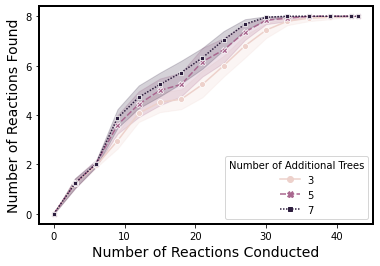

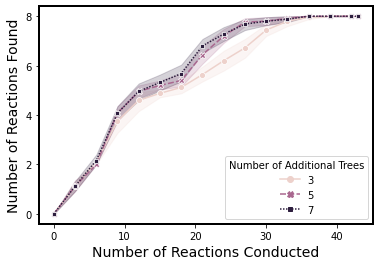

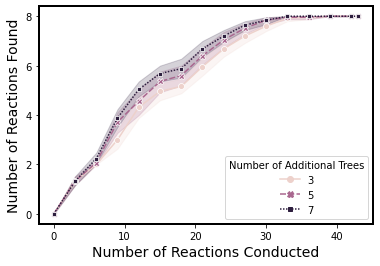

In [80]:
for i,source in enumerate(sources) :
    scenario = f"{source}_to_heterocycle"
    fig, ax = plt.subplots()
    sns.lineplot(x="num_rxns_conducted", y="num_rxns_found",
                 hue="Number of Additional Trees", style="Number of Additional Trees", markers=True,
                 ci=95,
                 data=adding_fixed_num_tree_system[scenario])
    ax.set_xlabel("Number of Reactions Conducted", fontsize=14)
    ax.set_ylabel("Number of Reactions Found", fontsize=14)
    ax.set_yticks(2*np.arange(5))
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    if i==0:
        fig.savefig("./figures/figure6.pdf", format="pdf", dpi=300)
    else : 
        fig.savefig(f"./figures/figureS9_{source}_add_fixed_trees.pdf",
                    format="pdf", dpi=300)

## 3) Adding trees every iteration

In [101]:
adding_tree_system = {}
adding_tree_models = {}

for i, source in enumerate(sources):
    # Preparing Random Models
    model_list = all_source_models[i]
    scenario = f"{source}_to_heterocycle"
    adding_tree_system.update({scenario:{
                "num_rxns_conducted":[],
                "num_rxns_found":[],
                "Strategy":[]
        }})
    adding_tree_models.update({scenario:{
                "models":[],
                "arrays":[]
        }})
    
    for j, model in enumerate(tqdm(model_list)):
        for strategy in ["Passive","Add 3 Trees", "No Source"]: # "No Source - 5 Trees", 
            if strategy in ["Passive", "Add 3 Trees"]:
                #print(f"    Add {num_trees} trees, random_state={42+k}")
                model_to_use = copy.deepcopy(model)
                print(f"        Starting with {len(model.estimators_)} Trees")
                if strategy=="Add 3 Trees":
                    rxns_collected_per_batch, confidence_selected_rxns,\
                    model_by_iter, num_found_by_batch = explore_target_in_batches(
                                model_to_use, source_desc[i], source_y[i],
                                het_desc, het_id, het_y, 
                                "confidence", "add_collected",
                                num_trees_to_add=3,
                                print_progress=False,
                                random_state=42+j
                            )
                elif strategy=="Passive" : 
                    rxns_collected_per_batch, confidence_selected_rxns,\
                    model_by_iter, num_found_by_batch = explore_target_in_batches(
                                model, source_desc[i], source_y[i],
                                het_desc, het_id, het_y, 
                                "confidence", "none", 
                                weight_factor=0, 
                                print_progress=False,
                                random_state=42+j
                            )
            else :
                np.random.seed(42+j)
                inds_to_shuffle = np.arange(len(het_y))
                np.random.shuffle(inds_to_shuffle)
                shuffled_y = [het_y[x] for x in inds_to_shuffle]
                first_zero = shuffled_y.index(0)
                init_num_batches = first_zero//3 +1
                init_inds = inds_to_shuffle[:3*init_num_batches]
                remaining_inds = [x for x in range(len(het_y)) if x not in init_inds]
                collected, remaining = divide_target_arrays(
                            het_desc, het_id, het_y, 
                            init_inds, remaining_inds
                        )
                
                first_num_found = len(collected[2]) - sum(collected[2])
                
                if strategy == "No Source":
                    rfc = RandomForestClassifier(max_depth=1, n_estimators=3*init_num_batches,
                                             random_state=42+j)
                    rfc.fit(collected[0], collected[2])
                
                    rxns_collected_per_batch, _,\
                    model_by_iter, num_found_by_batch = explore_target_in_batches(
                                    rfc, collected[0], collected[2],
                                    remaining[0], remaining[1], remaining[2],
                                    "confidence", "add_collected", 
                                    weight_factor=1, num_trees_to_add=3,
                                    print_progress=False,
                                    random_state=42+j, enough_found = 8-first_num_found
                                )

                rxns_collected_per_batch = [collected[3*i:3*(i+1)] for i in range(init_num_batches)] + rxns_collected_per_batch
                model_by_iter = ["None"]*(init_num_batches-1) + [rfc] + model_by_iter
                num_found_by_batch = [0]*(init_num_batches) + [first_num_found] + [x+1 for x in num_found_by_batch]
                print(init_num_batches, num_found_by_batch[:3]) #, len(rxns_collected_per_batch), len(num_found_by_batch))
                
            if len(num_found_by_batch)<16 : 
                num_found_by_batch += [num_found_by_batch[-1]]*(16-len(num_found_by_batch))
                adding_tree_system[scenario]["num_rxns_found"] += num_found_by_batch
            elif len(num_found_by_batch)==16:
                adding_tree_system[scenario]["num_rxns_found"] += num_found_by_batch
            adding_tree_system[scenario]["num_rxns_conducted"] += [3*x for x in range(15)]
            adding_tree_system[scenario]["num_rxns_conducted"] += [43]
            adding_tree_system[scenario]["Strategy"] += [strategy]*16
            adding_tree_models[scenario]["models"] += [model_by_iter]
            adding_tree_models[scenario]["arrays"] += [rxns_collected_per_batch]

        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  6
Number of trees:  9
Number of trees:  12
Number of trees:  15
Number of trees:  18
Number of trees:  21
Number of trees:  24
1 [0, 1.0, 1]
        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  15
Number of trees:  18
Number of trees:  21
Number of trees:  24
Number of trees:  27
Number of trees:  30
4 [0, 0, 0]
        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  6
Number of trees:  9
Number of trees:  12
Number of trees:  15
Number of trees:  18
Number of trees:  21
Num

Number of trees:  30
2 [0, 0, 1.0]
        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  9
Number of trees:  12
Number of trees:  15
Number of trees:  18
Number of trees:  21
Number of trees:  24
2 [0, 0, 1.0]
        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  6
Number of trees:  9
Number of trees:  12
Number of trees:  15
Number of trees:  18
Number of trees:  21
Number of trees:  24
Number of trees:  27
Number of trees:  30
1 [0, 1.0, 1]
        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number 

        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  6
Number of trees:  9
Number of trees:  12
Number of trees:  15
Number of trees:  18
Number of trees:  21
Number of trees:  24
1 [0, 1.0, 1]
        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  15
Number of trees:  18
Number of trees:  21
Number of trees:  24
Number of trees:  27
Number of trees:  30
4 [0, 0, 0]
        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  6
Number of trees:  9
Number of trees:  12
Num

Number of trees:  12
Number of trees:  15
Number of trees:  18
Number of trees:  21
Number of trees:  24
2 [0, 0, 1.0]
        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  6
Number of trees:  9
Number of trees:  12
Number of trees:  15
Number of trees:  18
Number of trees:  21
Number of trees:  24
Number of trees:  27
Number of trees:  30
1 [0, 1.0, 1]
        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  9
Number of trees:  12
Number of trees:  15
Number of trees:  18
Number of trees:  21
Number of trees:  24
Number of trees:  27
Number of trees:  30
Number of trees:  33
2 [0, 0, 2.0]
        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number 

        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  6
Number of trees:  9
Number of trees:  12
Number of trees:  15
Number of trees:  18
Number of trees:  21
Number of trees:  24
1 [0, 1.0, 1]
        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  15
Number of trees:  18
Number of trees:  21
Number of trees:  24
Number of trees:  27
Number of trees:  30
4 [0, 0, 0]
        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  6
Number of trees:  9
Number of trees:  12
Number of trees:  15
Num

Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  9
Number of trees:  12
Number of trees:  15
Number of trees:  18
Number of trees:  21
Number of trees:  24
2 [0, 0, 1.0]
        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  6
Number of trees:  9
Number of trees:  12
Number of trees:  15
Number of trees:  18
Number of trees:  21
Number of trees:  24
Number of trees:  27
Number of trees:  30
1 [0, 1.0, 1]
        Starting with 5 Trees
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  9
Number of trees:  12
Number of trees:  15
Number of trees:  18
Number of trees:  21
Number of trees:  

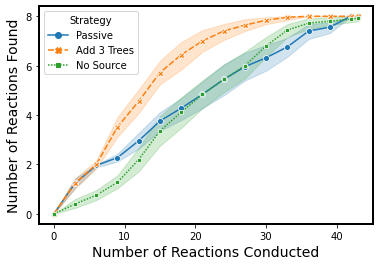

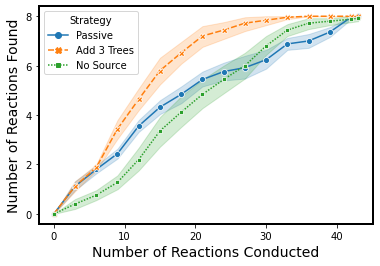

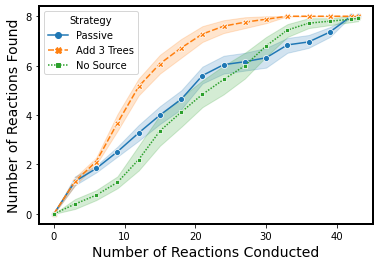

In [102]:
for i,source in enumerate(sources) :
    scenario = f"{source}_to_heterocycle"
    fig, ax = plt.subplots()
    sns.lineplot(x="num_rxns_conducted", y="num_rxns_found",
                 hue="Strategy", style="Strategy", markers=True,
                 ci=95,
                 data=adding_tree_system[scenario])
    ax.set_xlabel("Number of Reactions Conducted", fontsize=14)
    ax.set_ylabel("Number of Reactions Found", fontsize=14)
    ax.set_yticks(2*np.arange(5))
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    if i==0: 
        fig.savefig("./figures/figure7.pdf", format="pdf", dpi=300)
    else : 
        fig.savefig(f"./figures/figureS10_{source}_add_trees_each_iter.pdf",
                   format="pdf", dpi=300)

### Analysis

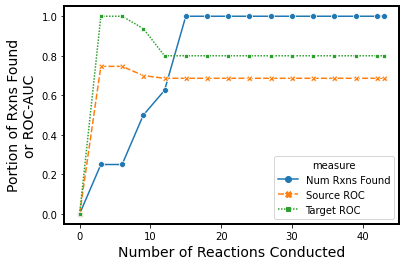

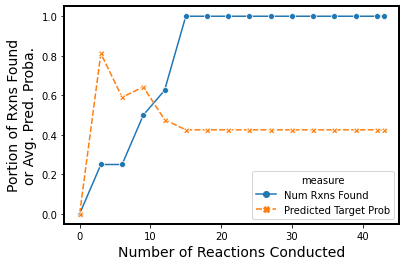

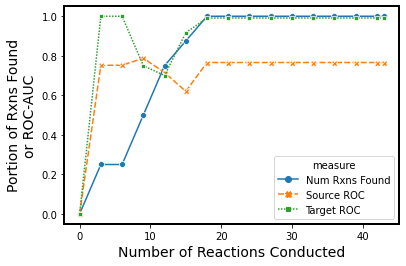

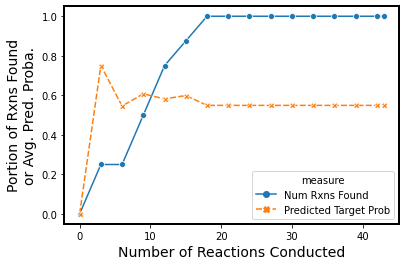

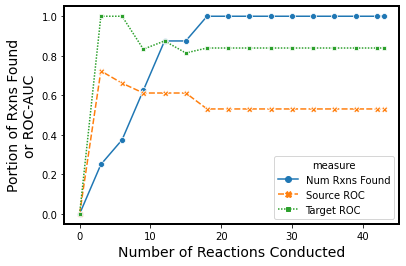

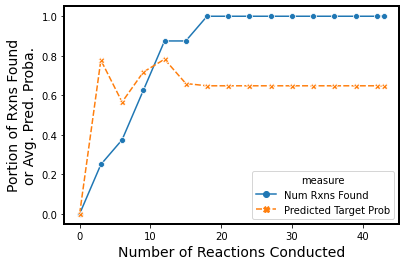

In [103]:
add_tree_areas = calc_area_by_scenario(adding_tree_system, num_weights=3)

for i, source in enumerate(sources):
    max_area_idx = np.argsort(add_tree_areas[f"{source}_to_heterocycle"][1,:])[-1]
    roc_source_rxns_best_system, roc_collected_rxns_best_system,\
    prob_desired_rxns_best_system  = get_roc_and_probs_by_batch(adding_tree_models, source, max_area_idx, 1,
                                                                source_desc[i], source_y[i],
                                                                num_weights_considered=3)    
    
    AL_and_ROC_best_system = prep_dict_to_plot_AL_and_ROC(adding_tree_system, source, max_area_idx, 1, 
                                                          roc_source_rxns_best_system,
                                                          roc_collected_rxns_best_system,
                                                          num_weights_considered=3)
    AL_and_prob_best_system = prep_dict_to_plot_AL_and_prob(adding_tree_system, source, max_area_idx, 1, 
                                                            prob_desired_rxns_best_system, 8,
                                                            num_weights_considered=3)
    if i==0 :
        plot_AL_and_ROC(AL_and_ROC_best_system, "ROC-AUC",  "figure8A_ROC_AUC")
        plot_AL_and_ROC(AL_and_prob_best_system, "Avg. Pred. Proba.", "figure8B_target_confidence")
    else :
        plot_AL_and_ROC(AL_and_ROC_best_system, "ROC-AUC",  f"figureS11_{source}_ROC_AUC")
        plot_AL_and_ROC(AL_and_prob_best_system, "Avg. Pred. Proba.", f"figureS11_{source}_target_confidence")

In [99]:
desc_idx = [0,6,33,58,65,73]
component_list = ["Nucleophile", "Electrophile", "Catalyst", "Base", "Solvent"]

def determine_component(feature_num, desc_idx=desc_idx):
    ''' Determines which component the descriptor comes from.
    
    Parameters
    ----------
    feature_num : int
        descriptor index
    desc_idx : list of ints
        index at which component descriptor starts.
    
    Returns
    -------
    i : int
        component index.
    '''
    for i in range(5):
        if feature_num >= desc_idx[i] and feature_num < desc_idx[i+1]:
            return i

def get_component_portion_per_batch(source, model_dict=adding_tree_models, num_models=25,
                                    num_weights_considered=3, weight_idx=1):
    '''Out of  ALL models considered for the AL experiment,
    computes which component descriptors are used in trees trained
    after each iteration.
    
    Parameters
    ----------
    source : str
        domain name.
    model_dict : dict
        result of AL experiment.
    num_weights_considered : int
    weight_idx : int
        index that we are interested in.
        
    Returns
    -------
    {source,batch1,batch2,batch3}_portion, : list
        portion of each components descriptor used in trees
        trained in each batch.
    '''
    source_count = [0,0,0,0,0]
    batch1_count = [0,0,0,0,0]
    batch2_count = [0,0,0,0,0]
    batch3_count = [0,0,0,0,0]

    for i in range(num_models):
        for j,dtc in enumerate(model_dict[f"{source}_to_heterocycle"]["models"][num_weights_considered*i+weight_idx][4].estimators_):
            feature = dtc.tree_.feature[0]
            if feature != -2:
                comp = determine_component(feature)
                if j < 5:
                    source_count[comp]+=1
                elif j < 8 : 
                    batch1_count[comp] += 1
                elif j < 11 : 
                    batch2_count[comp] += 1
                elif j < 14 :
                    batch3_count[comp] += 1

    source_portion = [x/sum(source_count) for x in source_count]
    batch1_portion = [x/sum(batch1_count) for x in batch1_count]
    batch2_portion = [x/sum(batch2_count) for x in batch2_count]
    batch3_portion = [x/sum(batch3_count) for x in batch3_count]
    
    return source_portion, batch1_portion, batch2_portion, batch3_portion


def plot_component_portions(source_portion, batch1_portion, batch2_portion, batch3_portion,
                           filename=None):
    ''' Plots the portions of descriptor components used in
    each batch of trees. '''
    labels = ['Source', 'Iter 1', 'Iter 2', 'Iter 3']

    x = np.arange(5)  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width*3/2, source_portion, width, label='Source')
    rects2 = ax.bar(x - width/2, batch1_portion, width, label='Iter 1')
    rects3 = ax.bar(x + width/2, batch2_portion, width, label="Iter 2")
    rects4 = ax.bar(x + width*3/2, batch3_portion, width, label="Iter 3")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_yticks([0.2*x for x in range(6)])
    ax.set_yticklabels([round(0.2*x,1) for x in range(6)])
    ax.set_ylabel('Portion of Descriptors', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(component_list)
    ax.set_xlabel("Reaction Component", fontsize=14)
    for i in range(4):
        ax.axvline(i+0.5, 0,1, c="gray", ls="--")
    ax.legend(bbox_to_anchor=(1.01,0.98))
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    if filename is not None :
        fig.savefig(f"./figures/{filename}.pdf", format="pdf", dpi=300)

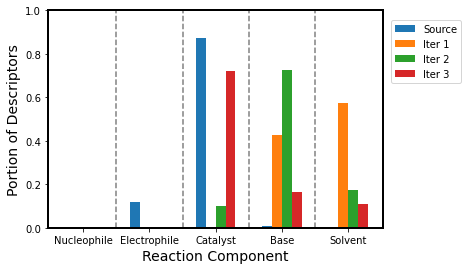

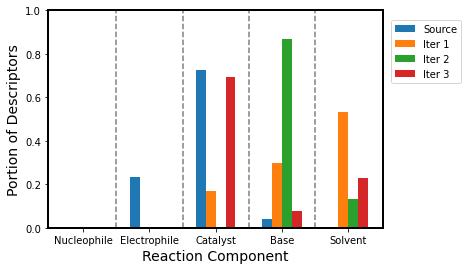

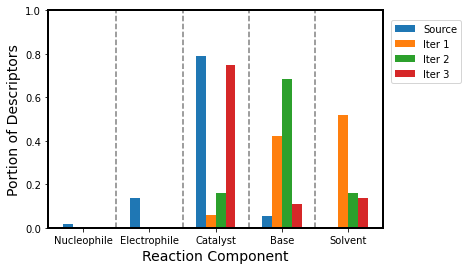

In [104]:
for i,source in enumerate(sources) : 
    source_portion, batch1_portion, batch2_portion, batch3_portion = get_component_portion_per_batch(source)
    if i==0 : 
        filename="figure8C"
    else :
        filename=f"figureS12_{source}"
    plot_component_portions(source_portion, batch1_portion, batch2_portion, batch3_portion, filename)

### 3-2) Adding different number of trees every iteration

In [117]:
adding_diff_tree_system = {}
adding_diff_tree_models = {}

for i, source in enumerate(sources):
    # Preparing Random Models
    model_list = all_source_models[i]
    scenario = f"{source}_to_heterocycle"
    adding_diff_tree_system.update({scenario:{
                "num_rxns_conducted":[],
                "num_rxns_found":[],
                "Number of\nTrees Added":[]
        }})
    adding_diff_tree_models.update({scenario:{
                "models":[],
                "arrays":[]
        }})
    
    for j, model in enumerate(tqdm(model_list)):
        for num_trees_to_add in [1,3,5]: 
            model_to_use = copy.deepcopy(model)
            print(f"        Starting with {len(model.estimators_)} Trees")
            rxns_collected_per_batch, confidence_selected_rxns,\
            model_by_iter, num_found_by_batch = explore_target_in_batches(
                                model_to_use, source_desc[i], source_y[i],
                                het_desc, het_id, het_y,
                                "confidence", "add_collected",
                                num_trees_to_add=num_trees_to_add,
                                print_progress=False,
                                random_state=42+j
                            )
            if len(num_found_by_batch)<16 : 
                num_found_by_batch += [num_found_by_batch[-1]]*(16-len(num_found_by_batch))
                adding_diff_tree_system[scenario]["num_rxns_found"] += num_found_by_batch
            elif len(num_found_by_batch)==16:
                adding_diff_tree_system[scenario]["num_rxns_found"] += num_found_by_batch
            adding_diff_tree_system[scenario]["num_rxns_conducted"] += [3*x for x in range(15)]
            adding_diff_tree_system[scenario]["num_rxns_conducted"] += [43]
            adding_diff_tree_system[scenario]["Number of\nTrees Added"] += [num_trees_to_add]*16
            adding_diff_tree_models[scenario]["models"] += [model_by_iter]
            adding_diff_tree_models[scenario]["arrays"] += [rxns_collected_per_batch]

        Starting with 5 Trees
Number of trees:  6
Number of trees:  7
Number of trees:  8
Number of trees:  9
Number of trees:  10
Number of trees:  11
Number of trees:  12
Number of trees:  13
Number of trees:  14
Number of trees:  15
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
        Starting with 5 Trees
Number of trees:  10
Number of trees:  15
Number of trees:  20
Number of trees:  25
Number of trees:  30
Number of trees:  35
        Starting with 5 Trees
Number of trees:  6
Number of trees:  7
Number of trees:  8
Number of trees:  9
Number of trees:  10
Number of trees:  11
Number of trees:  12
Number of trees:  13
Number of trees:  14
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
        Starting with 5 Trees
Number of trees:  10
Number of t

Number of trees:  25
Number of trees:  30
Number of trees:  35
Number of trees:  40
Number of trees:  45
Number of trees:  50
        Starting with 5 Trees
Number of trees:  6
Number of trees:  7
Number of trees:  8
Number of trees:  9
Number of trees:  10
Number of trees:  11
Number of trees:  12
Number of trees:  13
Number of trees:  14
Number of trees:  15
Number of trees:  16
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
        Starting with 5 Trees
Number of trees:  10
Number of trees:  15
Number of trees:  20
Number of trees:  25
Number of trees:  30
Number of trees:  35
Number of trees:  40
        Starting with 5 Trees
Number of trees:  6
Number of trees:  7
Number of trees:  8
Number of trees:  9
Number of trees:  10
Number of trees:  11
Number of trees:  12
Number of trees:  13
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11

        Starting with 5 Trees
Number of trees:  6
Number of trees:  7
Number of trees:  8
Number of trees:  9
Number of trees:  10
Number of trees:  11
Number of trees:  12
Number of trees:  13
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
        Starting with 5 Trees
Number of trees:  10
Number of trees:  15
Number of trees:  20
Number of trees:  25
Number of trees:  30
Number of trees:  35
Number of trees:  40
        Starting with 5 Trees
Number of trees:  6
Number of trees:  7
Number of trees:  8
Number of trees:  9
Number of trees:  10
Number of trees:  11
Number of trees:  12
Number of trees:  13
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
        Starting with 5 Trees
Number of trees:  10
Number of trees:  15
Number of t

Number of trees:  15
Number of trees:  16
Number of trees:  17
Number of trees:  18
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
        Starting with 5 Trees
Number of trees:  10
Number of trees:  15
Number of trees:  20
Number of trees:  25
Number of trees:  30
Number of trees:  35
Number of trees:  40
Number of trees:  45
Number of trees:  50
        Starting with 5 Trees
Number of trees:  6
Number of trees:  7
Number of trees:  8
Number of trees:  9
Number of trees:  10
Number of trees:  11
Number of trees:  12
Number of trees:  13
Number of trees:  14
Number of trees:  15
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
        Starting with 5 Trees
Number of trees:

        Starting with 5 Trees
Number of trees:  6
Number of trees:  7
Number of trees:  8
Number of trees:  9
Number of trees:  10
Number of trees:  11
Number of trees:  12
Number of trees:  13
Number of trees:  14
Number of trees:  15
Number of trees:  16
Number of trees:  17
Number of trees:  18
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
        Starting with 5 Trees
Number of trees:  10
Number of trees:  15
Number of trees:  20
Number of trees:  25
Number of trees:  30
Number of trees:  35
Number of trees:  40
        Starting with 5 Trees
Number of trees:  6
Number of trees:  7
Number of trees:  8
Number of trees:  9
Number of trees:  10
Number of trees:  11
Number of trees:  12
Number of trees:  13
Number of trees:  14
Number of trees:  15
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17

Number of trees:  14
Number of trees:  15
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
        Starting with 5 Trees
Number of trees:  10
Number of trees:  15
Number of trees:  20
Number of trees:  25
Number of trees:  30
Number of trees:  35
Number of trees:  40
Number of trees:  45
Number of trees:  50
        Starting with 5 Trees
Number of trees:  6
Number of trees:  7
Number of trees:  8
Number of trees:  9
Number of trees:  10
Number of trees:  11
Number of trees:  12
        Starting with 5 Trees
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
        Starting with 5 Trees
Number of trees:  10
Number of trees:  15
Number of trees:  20
Number of trees:  25
Number of trees:  30
Number of trees:  35
        Starting with 5 Trees
Number 

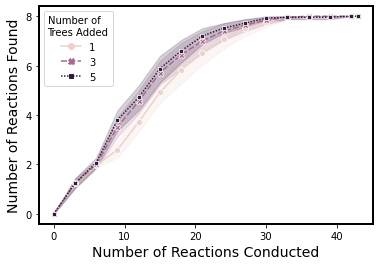

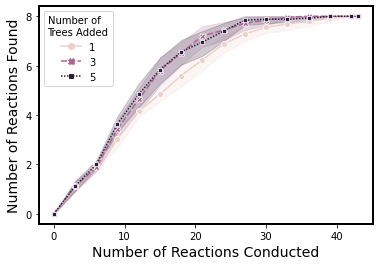

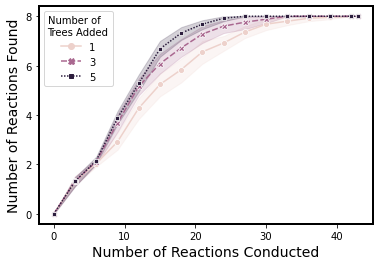

In [119]:
for i, source in enumerate(sources) :
    scenario = f"{source}_to_heterocycle"
    fig, ax = plt.subplots()
    sns.lineplot(x="num_rxns_conducted", y="num_rxns_found",
                 hue="Number of\nTrees Added", style="Number of\nTrees Added", markers=True,
                 ci=95,
                 data=adding_diff_tree_system[scenario])
    ax.set_xlabel("Number of Reactions Conducted", fontsize=14)
    ax.set_ylabel("Number of Reactions Found", fontsize=14)
    ax.set_yticks(2*np.arange(5))
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    fig.savefig(f"./figures/figureS13_{source}.pdf", format="pdf",
                dpi=300)

## 4) Comparing Selection strategies

### 4-1) Exploitation vs UCB vs Variance

In [133]:
adding_tree_ucb_system = {}
adding_tree_ucb_models = {}

for i, source in enumerate(sources):
    # Preparing Random Models
    model_list = all_source_models[i]
    scenario = f"{source}_to_heterocycle"
    adding_tree_ucb_system.update({scenario:{
                "num_rxns_conducted":[],
                "num_rxns_found":[],
                "Strategy":[],
                "std coefficient":[]
        }})
    adding_tree_ucb_models.update({scenario:{
                "models":[],
                "arrays":[]
        }})
    
    for k, model in enumerate(model_list):
        model_to_use = copy.deepcopy(model)
        for strategy in ["exploitation","ucb", "variance"]:
            if strategy=="ucb":
                for coeff in [0.5,2]:
                    rxns_collected_per_batch, confidence_selected_rxns,\
                    model_by_iter, num_found_by_batch = explore_target_in_batches(
                                            model_to_use, source_desc[i], source_y[i],
                                            het_desc, het_id, het_y,
                                            "ucb", "add_collected",
                                            num_trees_to_add=3,
                                            coeff=coeff,
                                            print_progress=False,
                                            random_state=42+k
                                        )
                    adding_tree_ucb_system[scenario]["std coefficient"] += [coeff]*16
                    if len(num_found_by_batch)<16 : 
                        num_found_by_batch += [num_found_by_batch[-1]]*(16-len(num_found_by_batch))
                        adding_tree_ucb_system[scenario]["num_rxns_found"] += num_found_by_batch
                    elif len(num_found_by_batch)==16:
                        adding_tree_ucb_system[scenario]["num_rxns_found"] += num_found_by_batch
                    adding_tree_ucb_system[scenario]["num_rxns_conducted"] += [3*x for x in range(15)]
                    adding_tree_ucb_system[scenario]["num_rxns_conducted"] += [43]
                    adding_tree_ucb_system[scenario]["Strategy"] += [strategy]*16
                    adding_tree_ucb_models[scenario]["models"] += [model_by_iter]
                    adding_tree_ucb_models[scenario]["arrays"] += [rxns_collected_per_batch]
            elif strategy == "variance":
                rxns_collected_per_batch, confidence_selected_rxns,\
                model_by_iter, num_found_by_batch = explore_target_in_batches(
                                            model_to_use, source_desc[i], source_y[i],
                                            het_desc, het_id, het_y,
                                            "variance", "add_collected",
                                            num_trees_to_add=3,
                                            print_progress=False,
                                            random_state=42+k
                                        )
                adding_tree_ucb_system[scenario]["std coefficient"] += [0]*16
                if len(num_found_by_batch)<16 : 
                    num_found_by_batch += [num_found_by_batch[-1]]*(16-len(num_found_by_batch))
                    adding_tree_ucb_system[scenario]["num_rxns_found"] += num_found_by_batch
                elif len(num_found_by_batch)==16:
                    adding_tree_ucb_system[scenario]["num_rxns_found"] += num_found_by_batch
                adding_tree_ucb_system[scenario]["num_rxns_conducted"] += [3*x for x in range(15)]
                adding_tree_ucb_system[scenario]["num_rxns_conducted"] += [43]
                adding_tree_ucb_system[scenario]["Strategy"] += [strategy]*16
                adding_tree_ucb_models[scenario]["models"] += [model_by_iter]
                adding_tree_ucb_models[scenario]["arrays"] += [rxns_collected_per_batch]
            else : 
                rxns_collected_per_batch, confidence_selected_rxns,\
                model_by_iter, num_found_by_batch = explore_target_in_batches(
                                            model_to_use, source_desc[i], source_y[i],
                                            het_desc, het_id, het_y,
                                            "confidence", "add_collected",
                                            num_trees_to_add=3,
                                            print_progress=False,
                                            random_state=42+k
                                        )
                adding_tree_ucb_system[scenario]["std coefficient"] += [0]*16
                
                if len(num_found_by_batch)<16 : 
                    num_found_by_batch += [num_found_by_batch[-1]]*(16-len(num_found_by_batch))
                    adding_tree_ucb_system[scenario]["num_rxns_found"] += num_found_by_batch
                elif len(num_found_by_batch)==16:
                    adding_tree_ucb_system[scenario]["num_rxns_found"] += num_found_by_batch
                adding_tree_ucb_system[scenario]["num_rxns_conducted"] += [3*x for x in range(15)]
                adding_tree_ucb_system[scenario]["num_rxns_conducted"] += [43]
                adding_tree_ucb_system[scenario]["Strategy"] += [strategy]*16
                adding_tree_ucb_models[scenario]["models"] += [model_by_iter]
                adding_tree_ucb_models[scenario]["arrays"] += [rxns_collected_per_batch]

Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  41
Number of trees:  44
Number of trees:  47
Number of trees:  50
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  

Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  41
Number of trees:  44
Number of trees:  47
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  8
Number of trees:  11
Number of trees:  

Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  41
Number of trees:  44
Number of trees:  47
Number of trees:  50
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  41
Number of trees:  44
Number of trees:  47
Number of trees:  50
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees: 

Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  41
Number of trees:  44
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  41
Number of trees:  44
Number of trees:  47
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  

Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  41
Number of trees:  44
Number of trees:  47
Number of trees:  50
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  41
Number of trees:  44
Number of trees:  47
Number of trees:  50
Number of trees:  8
Number of trees:  

Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  41
Number of trees:  44
Number of trees:  47
Number of trees:  50
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  41
Number of trees:  44
Number of trees:  47
Number of trees:  50
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees: 

Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  41
Number of trees:  44
Number of trees:  47
Number of trees:  50
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  

Number of trees:  26
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  41
Number of trees:  44
Number of trees:  47
Number of trees:  50
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  41
Number of trees:  44
Number of trees:  47
Number of trees:  8
Number of trees:  

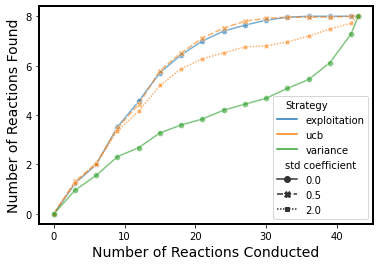

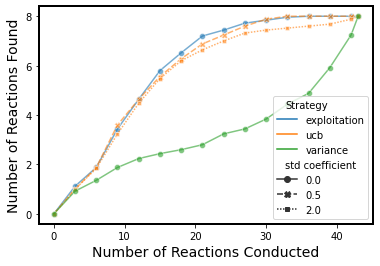

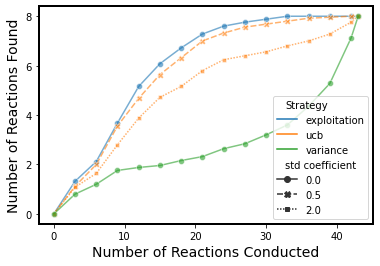

In [136]:
for source in sources :
    scenario = f"{source}_to_heterocycle"
    fig, ax = plt.subplots()
    sns.lineplot(x="num_rxns_conducted", y="num_rxns_found",
                 hue="Strategy", style="std coefficient",
                 markers=True, ci=None, alpha=0.6,
                 data=adding_tree_ucb_system[scenario])
    ax.set_xlabel("Number of Reactions Conducted", fontsize=14)
    ax.set_ylabel("Number of Reactions Found", fontsize=14)
    ax.set_yticks(2*np.arange(5))
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    fig.savefig(f"./figures/figureS14_{source}.pdf", format="pdf",
                dpi=300)

### 4-2) Initiating first few batches with high variance rxns

In [137]:
all_shift_perfs = {}
for i, source in enumerate(sources):
    model_list = all_source_models[i]
    scenario = f"{source}_to_heterocycle"
    all_shift_perfs.update({scenario:{
                    "num_rxns_conducted":[],
                    "num_rxns_found":[],
                    "Exploration Batches":[],
            }})
        
    for k, model in enumerate(model_list):
        for num_exp_batches in [0,1,2,4]:
            strategy_list = ["variance"]*num_exp_batches +\
                            ["confidence"]*(15-num_exp_batches)
            rxns_collected_per_batch, confidence_selected_rxns,\
            model_by_iter, num_found_by_batch = explore_target_in_batches(
                            model, source_desc[i], source_y[i],
                            het_desc, het_id, het_y,
                            strategy_list, "add_collected", 
                            num_trees_to_add=3, 
                            print_progress=False
                        )
                
            if len(num_found_by_batch)<16 : 
                num_found_by_batch += [num_found_by_batch[-1]]*(16-len(num_found_by_batch))
                all_shift_perfs[scenario]["num_rxns_found"] += num_found_by_batch
            elif len(num_found_by_batch)==16:
                all_shift_perfs[scenario]["num_rxns_found"] += num_found_by_batch
            all_shift_perfs[scenario]["num_rxns_conducted"] += [3*x for x in range(15)]
            all_shift_perfs[scenario]["num_rxns_conducted"] += [43]
            all_shift_perfs[scenario]["Exploration Batches"]+=[num_exp_batches]*16

Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26

Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  8
Number of trees:  1

Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  41
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  

Number of trees:  32
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  2

Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  

Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20

Number of trees:  38
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  35
Number of trees:  38
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  8
Number of trees:  11
Number of trees:  14
Number of trees:  17
Number of trees:  20
Number of trees:  23
Number of trees:  26
Number of trees:  29
Number of trees:  32
Number of trees:  3

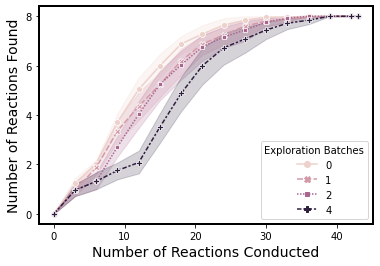

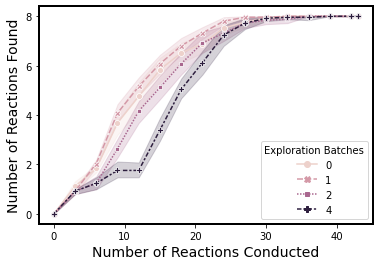

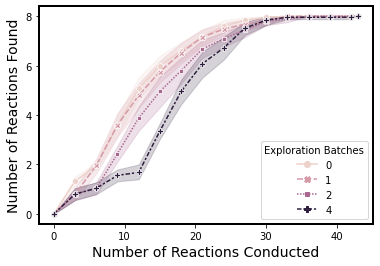

In [140]:
for source in sources :
    scenario = f"{source}_to_heterocycle"
    fig, ax = plt.subplots()
    sns.lineplot(x="num_rxns_conducted", y="num_rxns_found",
                 hue="Exploration Batches", style="Exploration Batches",
                 markers=True, ci=95,
                 data=all_shift_perfs[scenario])
    ax.set_xlabel("Number of Reactions Conducted", fontsize=14)
    ax.set_ylabel("Number of Reactions Found", fontsize=14)
    ax.set_yticks(2*np.arange(5))
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    fig.savefig(f"./figures/figureS15_{source}.pdf", format="pdf",
                dpi=300)